In [109]:
import os
import pickle

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from constants import Constants as const
from dataloader.supervised.generation.action_genome.ag_dataset import cuda_collate_fn

In [110]:
class AGDataset(Dataset):
    def __init__(
            self,
            phase,
            datasize,
            data_path=None,
            filter_nonperson_box_frame=True,
            filter_small_box=False
    ):

        root_path = data_path
        self.frames_path = os.path.join(root_path, const.FRAMES)

        # collect the object classes
        self.object_classes = [const.BACKGROUND]

        with open(os.path.join(root_path, const.ANNOTATIONS, const.OBJECT_CLASSES_FILE), 'r',
                  encoding='utf-8') as f:
            for line in f.readlines():
                line = line.strip('\n')
                self.object_classes.append(line)
        f.close()
        self.object_classes[9] = 'closet/cabinet'
        self.object_classes[11] = 'cup/glass/bottle'
        self.object_classes[23] = 'paper/notebook'
        self.object_classes[24] = 'phone/camera'
        self.object_classes[31] = 'sofa/couch'

        # collect relationship classes
        self.relationship_classes = []
        with open(os.path.join(root_path, const.ANNOTATIONS, const.RELATIONSHIP_CLASSES_FILE), 'r') as f:
            for line in f.readlines():
                line = line.strip('\n')
                self.relationship_classes.append(line)
        f.close()
        self.relationship_classes[0] = 'looking_at'
        self.relationship_classes[1] = 'not_looking_at'
        self.relationship_classes[5] = 'in_front_of'
        self.relationship_classes[7] = 'on_the_side_of'
        self.relationship_classes[10] = 'covered_by'
        self.relationship_classes[11] = 'drinking_from'
        self.relationship_classes[13] = 'have_it_on_the_back'
        self.relationship_classes[15] = 'leaning_on'
        self.relationship_classes[16] = 'lying_on'
        self.relationship_classes[17] = 'not_contacting'
        self.relationship_classes[18] = 'other_relationship'
        self.relationship_classes[19] = 'sitting_on'
        self.relationship_classes[20] = 'standing_on'
        self.relationship_classes[25] = 'writing_on'

        self.attention_relationships = self.relationship_classes[0:3]
        self.spatial_relationships = self.relationship_classes[3:9]
        self.contacting_relationships = self.relationship_classes[9:]

        print('-------loading annotations---------slowly-----------')

        annotations_path = os.path.join(root_path, const.ANNOTATIONS)
        if filter_small_box:
            with open(os.path.join(annotations_path, const.PERSON_BOUNDING_BOX_PKL), 'rb') as f:
                person_bbox = pickle.load(f)
            f.close()
            with open('dataloader/object_bbox_and_relationship_filtersmall.pkl', 'rb') as f:
                object_bbox = pickle.load(f)
        else:
            with open(os.path.join(annotations_path, const.PERSON_BOUNDING_BOX_PKL), 'rb') as f:
                person_bbox = pickle.load(f)
            f.close()
            with open(os.path.join(annotations_path, const.OBJECT_BOUNDING_BOX_RELATIONSHIP_PKL), 'rb') as f:
                object_bbox = pickle.load(f)
            f.close()
        print('--------------------finish!-------------------------')

        if datasize == const.MINI:
            small_person = {}
            small_object = {}
            for i in list(person_bbox.keys())[:80000]:
                small_person[i] = person_bbox[i]
                small_object[i] = object_bbox[i]
            person_bbox = small_person
            object_bbox = small_object

        # collect valid frames
        video_dict = {}
        q = []
        for i in person_bbox.keys():
            if object_bbox[i][0][const.METADATA][const.SET] == phase:  # train or testing?
                video_name, frame_num = i.split('/')
                q.append(video_name)
                frame_valid = False
                for j in object_bbox[i]:  # the frame is valid if there is visible bbox
                    if j[const.VISIBLE]:
                        frame_valid = True
                if frame_valid:
                    video_name, frame_num = i.split('/')
                    if video_name in video_dict.keys():
                        video_dict[video_name].append(i)
                    else:
                        video_dict[video_name] = [i]

        all_video_names = np.unique(q)
        self.valid_video_names = []
        self.video_list = []
        self.video_size = []  # (w,h)
        self.gt_annotations = []
        self.non_gt_human_nums = 0
        self.non_heatmap_nums = 0
        self.non_person_video = 0
        self.one_frame_video = 0
        self.valid_nums = 0
        self.invalid_videos = []

        '''
            filter_nonperson_box_frame = True (default): according to the stanford method, remove the frames without person box both for training and testing
            filter_nonperson_box_frame = False: still use the frames without person box, FasterRCNN may find the person
            '''
        for i in video_dict.keys():
            video = []
            gt_annotation_video = []
            for j in video_dict[i]:
                if filter_nonperson_box_frame:
                    if person_bbox[j][const.BOUNDING_BOX].shape[0] == 0:
                        self.non_gt_human_nums += 1
                        continue
                    else:
                        video.append(j)
                        self.valid_nums += 1

                gt_annotation_frame = [
                    {
                        const.PERSON_BOUNDING_BOX: person_bbox[j][const.BOUNDING_BOX],
                        const.FRAME: j
                    }
                ]

                # each frame's objects and human
                for k in object_bbox[j]:
                    if k[const.VISIBLE]:
                        assert k[const.BOUNDING_BOX] is not None, 'warning! The object is visible without bbox'
                        k[const.CLASS] = self.object_classes.index(k[const.CLASS])
                        # from xywh to xyxy
                        k[const.BOUNDING_BOX] = np.array([
                            k[const.BOUNDING_BOX][0], k[const.BOUNDING_BOX][1],
                            k[const.BOUNDING_BOX][0] + k[const.BOUNDING_BOX][2],
                            k[const.BOUNDING_BOX][1] + k[const.BOUNDING_BOX][3]
                        ])

                        k[const.ATTENTION_RELATIONSHIP] = torch.tensor(
                            [self.attention_relationships.index(r) for r in k[const.ATTENTION_RELATIONSHIP]],
                            dtype=torch.long)
                        k[const.SPATIAL_RELATIONSHIP] = torch.tensor(
                            [self.spatial_relationships.index(r) for r in k[const.SPATIAL_RELATIONSHIP]],
                            dtype=torch.long)
                        k[const.CONTACTING_RELATIONSHIP] = torch.tensor(
                            [self.contacting_relationships.index(r) for r in k[const.CONTACTING_RELATIONSHIP]],
                            dtype=torch.long)
                        gt_annotation_frame.append(k)
                gt_annotation_video.append(gt_annotation_frame)

            if len(video) > 2:
                self.video_list.append(video)
                self.video_size.append(person_bbox[j][const.BOUNDING_BOX_SIZE])
                self.gt_annotations.append(gt_annotation_video)
            elif len(video) == 1:
                self.one_frame_video += 1
            else:
                self.non_person_video += 1

        print('x' * 60)
        if filter_nonperson_box_frame:
            print('There are {} videos and {} valid frames'.format(len(self.video_list), self.valid_nums))
            print('{} videos are invalid (no person), remove them'.format(self.non_person_video))
            print('{} videos are invalid (only one frame), remove them'.format(self.one_frame_video))
            print('{} frames have no human bbox in GT, remove them!'.format(self.non_gt_human_nums))
        else:
            print('There are {} videos and {} valid frames'.format(len(self.video_list), self.valid_nums))
            print('{} frames have no human bbox in GT'.format(self.non_gt_human_nums))
            print(
                'Removed {} of them without joint heatmaps which means FasterRCNN also cannot find the human'.format(
                    self.non_heatmap_nums))
        print('x' * 60)

        self.invalid_video_names = np.setdiff1d(all_video_names, self.valid_video_names, assume_unique=False)

    def __getitem__(self, index):
        gt_annotation = self.gt_annotations[index]
        return gt_annotation

    def __len__(self):
        return len(self.video_list)

In [111]:
annotations_directory = "/data/rohith/ag"
train_dataset = AGDataset(phase=const.TRAIN, datasize=const.LARGE, data_path=annotations_directory)

ag_train_dataloader = DataLoader(
    train_dataset,
    shuffle=False,
    num_workers=0,
    collate_fn=cuda_collate_fn,
    pin_memory=False
)

-------loading annotations---------slowly-----------
--------------------finish!-------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
There are 7584 videos and 177330 valid frames
144 videos are invalid (no person), remove them
49 videos are invalid (only one frame), remove them
21643 frames have no human bbox in GT, remove them!
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [112]:
class Video:

    def __init__(self, video_id):
        self.video_id = video_id
        self.object_frame_presence_dict = {}
        self.frame_wise_change_statistics = {}
        self.total_num_frames = None
        self.object_total_frames = {}

    def add_object_frame_presence(self, object_id, frame_number):
        if object_id not in self.object_frame_presence_dict:
            self.object_frame_presence_dict[object_id] = []
        self.object_frame_presence_dict[object_id].append(frame_number)

    def preprocess_from_gt_annotations(self, gt_annotations):
        # print(f"Preprocessing video {self.video_id} using gt_annotations of length: {len(gt_annotations)}")
        total_num_frames = len(gt_annotations)
        self.total_num_frames = total_num_frames
        person_id = "1"
        for frame_gt_annotations in gt_annotations:
            frame_number = int(frame_gt_annotations[0][const.FRAME].split('/')[1][:-4])
            self.add_object_frame_presence(person_id, frame_number)
            
            if person_id in self.object_total_frames:
                self.object_total_frames[person_id] += 1
            else:
                self.object_total_frames[person_id] = 1
            for object_gt_annotation in frame_gt_annotations[1:]:
                object_id = object_gt_annotation["class"]
                self.add_object_frame_presence(object_id, frame_number)
                
                if object_id in self.object_total_frames:
                    self.object_total_frames[object_id] += 1
                else:
                    self.object_total_frames[object_id] = 1             

In [97]:
processed_train_video_list = []
for video_gt_annotations in tqdm(ag_train_dataloader):
    num_frames_video = len(video_gt_annotations)
    video_id = video_gt_annotations[0][0][const.FRAME].split('/')[0]
    video = Video(video_id=video_id)
    video.preprocess_from_gt_annotations(video_gt_annotations)
    processed_train_video_list.append(video)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7584/7584 [00:02<00:00, 3061.53it/s]


# COMPLETE DATASET: Observation Ratio of Video Frames: 30%, 50%, 70%, 90%

## TRAIN DATASET

In [113]:
context_fractions = [0.3, 0.5, 0.7, 0.9]

In [114]:
def fetch_cf_details(processed_video_list):
    cf_total_videos = {}
    tf_total_objects = {}
    cf_total_objects = {}
    cf_disappearing_objects = {}
    cf_appearing_objects = {}
    cf_re_appearing_objects = {}
    
    for context_fraction in context_fractions:
        cf_total_objects[context_fraction] = 0
        cf_disappearing_objects[context_fraction] = 0
        cf_appearing_objects[context_fraction] = 0
        cf_re_appearing_objects[context_fraction] = 0
        cf_total_videos[context_fraction] = 0
        tf_total_objects[context_fraction] = 0
    
        for video in tqdm(processed_video_list):
            total_num_frames = video.total_num_frames
            cf_num_frames = int(total_num_frames * context_fraction)
    
            person_id = "1"
            tf_frame_number_list = video.object_frame_presence_dict[person_id]
            person_cf_num_frame_list = tf_frame_number_list[:cf_num_frames]
            person_ff_frame_list = tf_frame_number_list[cf_num_frames:]
    
            if len(person_cf_num_frame_list) == 0:
                continue
    
            cf_total_videos[context_fraction] += 1
    
            assert len(person_cf_num_frame_list) > 0, f"Found person context frames number list {len(person_cf_num_frame_list)}"
            lcf = person_cf_num_frame_list[-1]
    
            # Objects in last context frame of the context fraction
            lcf_obj_set = set()
            app_obj_set = set()
            reapp_obj_set = set()
            tf_obj_id_list = list(video.object_frame_presence_dict.keys())
            tf_obj_id_list.remove(person_id)
            
            tf_total_objects[context_fraction] += len(tf_obj_id_list)
            for obj_id in tf_obj_id_list:
                obj_tf_frame_list = video.object_frame_presence_dict[obj_id]
                if lcf in obj_tf_frame_list:
                    lcf_obj_set.add(obj_id)
                elif lcf < obj_tf_frame_list[0]:
                    app_obj_set.add(obj_id)
                elif obj_tf_frame_list[0] < lcf < obj_tf_frame_list[-1]:
                    reapp_obj_set.add(obj_id)
    
            # Update appearing objects
            cf_appearing_objects[context_fraction] += len(app_obj_set)
            # Update re-appearing objects
            cf_re_appearing_objects[context_fraction] += len(reapp_obj_set)
    
            for obj_id in lcf_obj_set:
                cf_total_objects[context_fraction] += 1
                # Update future frames disappearance list
                obj_tf_num_frame_list = video.object_frame_presence_dict[obj_id]
                obj_ff_frame_list = list(np.array(obj_tf_num_frame_list)[np.array(obj_tf_num_frame_list) >= lcf])
                if len(obj_ff_frame_list) < 0.9*len(person_ff_frame_list):
                    cf_disappearing_objects[context_fraction] += 1
    return cf_total_videos, cf_total_objects, cf_disappearing_objects, cf_appearing_objects, cf_re_appearing_objects, tf_total_objects

In [115]:
cf_train_total_videos, cf_train_total_objects, cf_train_disappearing_objects, cf_train_appearing_objects, cf_train_re_appearing_objects, tf_train_total_objects = fetch_cf_details(processed_train_video_list)

print(f"Total Videos: {cf_train_total_videos}")
print(f"Total Objects in last context frame: {cf_train_total_objects}")
print(f"Total disappearing objects: {cf_train_disappearing_objects}")
print(f"Total appearing objects: {cf_train_appearing_objects}")
print(f"Total re-appearing objects: {cf_train_re_appearing_objects}")
print(f"Total Objects: {tf_train_total_objects}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7584/7584 [00:00<00:00, 45004.40it/s]

Total Videos: {0.3: 7509, 0.5: 7584, 0.7: 7584, 0.9: 7584}
Total Objects in last context frame: {0.3: 15074, 0.5: 15910, 0.7: 15582, 0.9: 14194}
Total disappearing objects: {0.3: 7712, 0.5: 6719, 0.7: 4771, 0.9: 1585}
Total appearing objects: {0.3: 7295, 0.5: 4108, 0.7: 1839, 0.9: 326}
Total re-appearing objects: {0.3: 1075, 0.5: 1419, 0.7: 1335, 0.9: 760}
Total Objects: {0.3: 24474, 0.5: 24604, 0.7: 24604, 0.9: 24604}


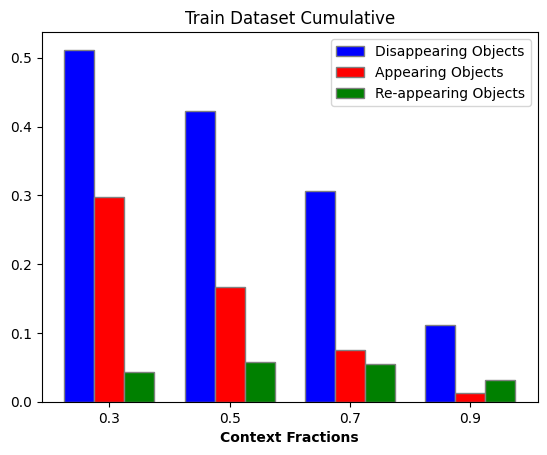

In [116]:
import matplotlib.pyplot as plt
def plot_object_changes(cf_total_objects, cf_disappearing_objects, cf_appearing_objects, cf_re_appearing_objects, tf_total_objects, title_name="Object Changes"):    
    # Probabilities of objects disappearing, appearing and re-appearing
    p_disappearing_objects = {}
    p_appearing_objects = {}
    p_re_appearing_objects = {}
    
    for context_fraction in context_fractions:
        p_disappearing_objects[context_fraction] = cf_disappearing_objects[context_fraction] / cf_total_objects[context_fraction]
        p_appearing_objects[context_fraction] = cf_appearing_objects[context_fraction] / tf_total_objects[context_fraction]
        p_re_appearing_objects[context_fraction] = cf_re_appearing_objects[context_fraction] / tf_total_objects[context_fraction]
    
    barWidth = 0.25
    bars1 = [p_disappearing_objects[context_fraction] for context_fraction in context_fractions]
    bars2 = [p_appearing_objects[context_fraction] for context_fraction in context_fractions]
    bars3 = [p_re_appearing_objects[context_fraction] for context_fraction in context_fractions]
    
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Disappearing Objects')
    plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Appearing Objects')
    plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='Re-appearing Objects')
    
    plt.xlabel('Context Fractions', fontweight='bold')
    plt.title(f'{title_name}')
    plt.xticks([r + barWidth for r in range(len(bars1))], context_fractions)
    plt.legend()
    plt.show()
    
plot_object_changes(cf_train_total_objects, cf_train_disappearing_objects, cf_train_appearing_objects, cf_train_re_appearing_objects, tf_train_total_objects, title_name="Train Dataset Cumulative")  

## TEST DATASET

In [117]:
annotations_directory = "/data/rohith/ag"
test_dataset = AGDataset(phase=const.TEST, datasize=const.LARGE, data_path=annotations_directory)

ag_test_dataloader = DataLoader(
    test_dataset,
    shuffle=False,
    num_workers=0,
    collate_fn=cuda_collate_fn,
    pin_memory=False
)

-------loading annotations---------slowly-----------
--------------------finish!-------------------------
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
There are 1750 videos and 56923 valid frames
41 videos are invalid (no person), remove them
19 videos are invalid (only one frame), remove them
8636 frames have no human bbox in GT, remove them!
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [118]:
processed_test_video_list = []
for video_gt_annotations in tqdm(ag_test_dataloader):
    num_frames_video = len(video_gt_annotations)
    video_id = video_gt_annotations[0][0][const.FRAME].split('/')[0]
    video = Video(video_id=video_id)
    video.preprocess_from_gt_annotations(video_gt_annotations)
    processed_test_video_list.append(video)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:00<00:00, 2429.04it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:00<00:00, 33311.54it/s]


Total Videos: {0.3: 1740, 0.5: 1750, 0.7: 1750, 0.9: 1750}
Total Objects in last context frame: {0.3: 4368, 0.5: 4559, 0.7: 4394, 0.9: 3986}
Total disappearing objects: {0.3: 2328, 0.5: 2063, 0.7: 1457, 0.9: 573}
Total appearing objects: {0.3: 2084, 0.5: 1189, 0.7: 516, 0.9: 107}
Total re-appearing objects: {0.3: 409, 0.5: 512, 0.7: 497, 0.9: 290}
Total Objects: {0.3: 7249, 0.5: 7273, 0.7: 7273, 0.9: 7273}


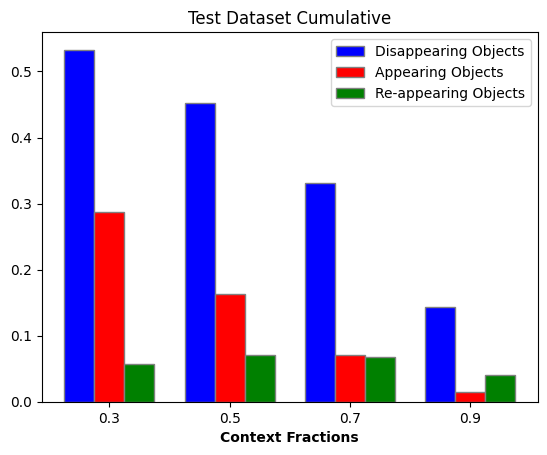

In [119]:
cf_test_total_videos, cf_test_total_objects, cf_test_disappearing_objects, cf_test_appearing_objects, cf_test_re_appearing_objects, tf_test_total_objects = fetch_cf_details(processed_test_video_list)

print(f"Total Videos: {cf_test_total_videos}")
print(f"Total Objects in last context frame: {cf_test_total_objects}")
print(f"Total disappearing objects: {cf_test_disappearing_objects}")
print(f"Total appearing objects: {cf_test_appearing_objects}")
print(f"Total re-appearing objects: {cf_test_re_appearing_objects}")
print(f"Total Objects: {tf_test_total_objects}")

plot_object_changes(cf_test_total_objects, cf_test_disappearing_objects, cf_test_appearing_objects, cf_test_re_appearing_objects, tf_test_total_objects, title_name="Test Dataset Cumulative")

# PER VIDEO: Observation Ratio of Video Frames: 30%, 50%, 70%, 90%

## TRAIN DATASET

In [121]:
def fetch_per_video_cf_details(processed_video_list):
    cf_disappearing_objects = {}
    cf_appearing_objects = {}
    cf_re_appearing_objects = {}
    
    for context_fraction in context_fractions:
        cf_disappearing_objects[context_fraction] = 0
        cf_appearing_objects[context_fraction] = 0
        cf_re_appearing_objects[context_fraction] = 0
    
        for video in tqdm(processed_video_list):
            total_num_frames = video.total_num_frames
            cf_num_frames = int(total_num_frames * context_fraction)
    
            person_id = "1"
            tf_frame_number_list = video.object_frame_presence_dict[person_id]
            person_cf_num_frame_list = tf_frame_number_list[:cf_num_frames]
            person_ff_frame_list = tf_frame_number_list[cf_num_frames:]
    
            if len(person_cf_num_frame_list) == 0:
                continue
    
            assert len(person_cf_num_frame_list) > 0, f"Found person context frames number list {len(person_cf_num_frame_list)}"
            lcf = person_cf_num_frame_list[-1]
    
            # Objects in last context frame of the context fraction
            lcf_obj_set = set()
            app_obj_set = set()
            reapp_obj_set = set()
            tf_obj_id_list = list(video.object_frame_presence_dict.keys())
            tf_obj_id_list.remove(person_id)
            
            for obj_id in tf_obj_id_list:
                obj_tf_frame_list = video.object_frame_presence_dict[obj_id]
                if lcf in obj_tf_frame_list:
                    lcf_obj_set.add(obj_id)
                elif lcf < obj_tf_frame_list[0]:
                    app_obj_set.add(obj_id)
                elif obj_tf_frame_list[0] < lcf < obj_tf_frame_list[-1]:
                    reapp_obj_set.add(obj_id)
    
            # Update appearing objects
            cf_appearing_objects[context_fraction] += (len(app_obj_set)/len(tf_obj_id_list))
            # Update re-appearing objects
            cf_re_appearing_objects[context_fraction] += (len(reapp_obj_set)/len(tf_obj_id_list))
            
            disapp_obj_set = set()
            for obj_id in lcf_obj_set:
                # Update future frames disappearance list
                obj_tf_num_frame_list = video.object_frame_presence_dict[obj_id]
                obj_ff_frame_list = list(np.array(obj_tf_num_frame_list)[np.array(obj_tf_num_frame_list) >= lcf])
                if len(obj_ff_frame_list) < 0.9*len(person_ff_frame_list):
                    disapp_obj_set.add(obj_id)
                    
            # Update disappearing objects
            cf_disappearing_objects[context_fraction] += (len(disapp_obj_set)/len(lcf_obj_set))                    
            
    return cf_disappearing_objects, cf_appearing_objects, cf_re_appearing_objects

In [122]:
cf_train_per_video_disappearing_objects, cf_train_per_video_appearing_objects, cf_train_per_video_re_appearing_objects = fetch_per_video_cf_details(processed_train_video_list)

print(f"Total disappearing objects: {cf_train_per_video_disappearing_objects}")
print(f"Total appearing objects: {cf_train_per_video_appearing_objects}")
print(f"Total re-appearing objects: {cf_train_per_video_re_appearing_objects}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7584/7584 [00:00<00:00, 43577.01it/s]

Total disappearing objects: {0.3: 3932.185714285717, 0.5: 3177.0964285714385, 0.7: 2166.657142857139, 0.9: 692.5833333333342}
Total appearing objects: {0.3: 2012.741666666662, 0.5: 1119.1087301587386, 0.7: 496.16825396825, 0.9: 85.81984126984132}
Total re-appearing objects: {0.3: 295.6845238095231, 0.5: 394.12499999999795, 0.7: 376.37698412698217, 0.9: 213.82182539682523}


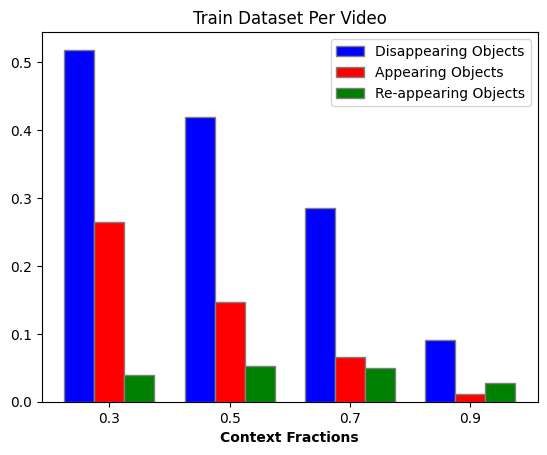

In [123]:
import matplotlib.pyplot as plt
def plot_object_changes_per_video(cf_disappearing_objects, cf_appearing_objects, cf_re_appearing_objects, total_videos, title_name="Object Changes"):    
    # Probabilities of objects disappearing, appearing and re-appearing
    p_disappearing_objects = {}
    p_appearing_objects = {}
    p_re_appearing_objects = {}
    
    for context_fraction in context_fractions:
        p_disappearing_objects[context_fraction] = cf_disappearing_objects[context_fraction] / total_videos
        p_appearing_objects[context_fraction] = cf_appearing_objects[context_fraction] / total_videos
        p_re_appearing_objects[context_fraction] = cf_re_appearing_objects[context_fraction] / total_videos
    
    barWidth = 0.25
    bars1 = [p_disappearing_objects[context_fraction] for context_fraction in context_fractions]
    bars2 = [p_appearing_objects[context_fraction] for context_fraction in context_fractions]
    bars3 = [p_re_appearing_objects[context_fraction] for context_fraction in context_fractions]
    
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    
    plt.bar(r1, bars1, color='b', width=barWidth, edgecolor='grey', label='Disappearing Objects')
    plt.bar(r2, bars2, color='r', width=barWidth, edgecolor='grey', label='Appearing Objects')
    plt.bar(r3, bars3, color='g', width=barWidth, edgecolor='grey', label='Re-appearing Objects')
    
    plt.xlabel('Context Fractions', fontweight='bold')
    plt.title(f'{title_name}')
    plt.xticks([r + barWidth for r in range(len(bars1))], context_fractions)
    plt.legend()
    plt.show()
    
plot_object_changes_per_video(cf_train_per_video_disappearing_objects, cf_train_per_video_appearing_objects, cf_train_per_video_re_appearing_objects, len(processed_train_video_list),  title_name="Train Dataset Per Video")  

## TEST DATASET

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1750/1750 [00:00<00:00, 34365.86it/s]


Total disappearing objects: {0.3: 947.8630952380953, 0.5: 795.2928571428572, 0.7: 557.9642857142858, 0.9: 224.07500000000005}
Total appearing objects: {0.3: 463.38185425685276, 0.5: 257.3869408369404, 0.7: 112.09289321789339, 0.9: 22.98373015873014}
Total re-appearing objects: {0.3: 86.75447330447341, 0.5: 110.17976190476206, 0.7: 110.15162337662352, 0.9: 63.21904761904769}


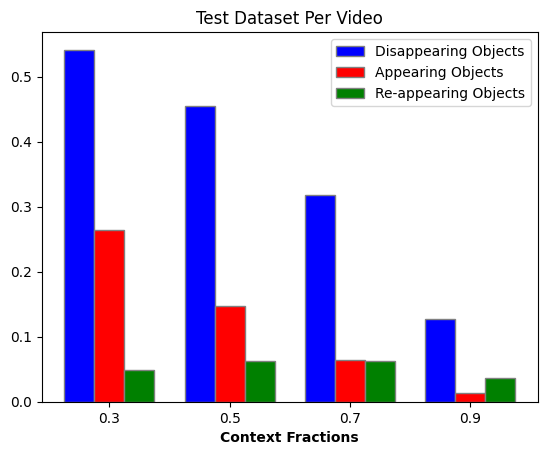

In [124]:
cf_test_per_video_disappearing_objects, cf_test_per_video_appearing_objects, cf_test_per_video_re_appearing_objects = fetch_per_video_cf_details(processed_test_video_list)

print(f"Total disappearing objects: {cf_test_per_video_disappearing_objects}")
print(f"Total appearing objects: {cf_test_per_video_appearing_objects}")
print(f"Total re-appearing objects: {cf_test_per_video_re_appearing_objects}")


plot_object_changes_per_video(cf_test_per_video_disappearing_objects, cf_test_per_video_appearing_objects, cf_test_per_video_re_appearing_objects, len(processed_test_video_list),  title_name="Test Dataset Per Video")  